### Mercari Price 
The files consist of a list of product listings. These files are tab-delimited.

Fields:
- train_id or test_id - the id of the listing

- name - the title of the listing. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid  leakage. These removed prices are represented as [rm]

- item_condition_id - the condition of the items provided by the seller

- category_name - category of the listing

- brand_name

- price - the price that the item was sold for. This is the target variable that you will predict. The unit is USD. This column doesn't exist in test.tsv since that is what you will predict.

- shipping - 1 if shipping fee is paid by seller and 0 by buyer

- item_description - the full description of the item. Note that we have cleaned the data to remove text that look like prices (e.g. $20) to avoid leakage. These removed prices are represented as [rm]

## Setup

In [1]:
! pip install pydot graphviz emoji transformers

import pandas as pd
import numpy as np

from nltk.tokenize import word_tokenize
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import tensorflow.keras.backend as K


from tqdm._tqdm_notebook import tqdm_notebook

import os
import itertools

import matplotlib.pyplot as plt
import itertools
from collections import Counter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import Dense, Input, Embedding, Concatenate, Flatten, Dropout, LSTM, GlobalMaxPool1D, GRU, Bidirectional, GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from nltk.corpus import stopwords
import string

import pickle

from tensorflow.keras.preprocessing.text import text_to_word_sequence 
from nltk.stem import WordNetLemmatizer

from nltk.tokenize import TweetTokenizer

import emoji
import os

from sklearn.feature_extraction.text import CountVectorizer

import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel, pipeline

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')


stop_words = set(stopwords.words('english'))
stop_words.remove("no")

tqdm_notebook.pandas()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  app.launch_new_instance()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
msle = tf.keras.losses.MeanSquaredLogarithmicError()

def root_mean_squared_logarithmic_error(y_true, y_pred):
    return K.sqrt(msle(y_true, y_pred))

## Colab

In [3]:
RunningInCOLAB = 'google.colab' in str(get_ipython())

# check if in colab
if RunningInCOLAB and not os.path.isdir('/content/gdrive'):
    print("Running in colab")
    from google.colab import drive
    drive.mount('/content/gdrive', force_remount=True)
    colab_root = '/content/drive'
      
if RunningInCOLAB:
    root_dir = "/content/gdrive/My Drive/"
    base_dir = root_dir + 'project-mercari-price/'
    if not os.path.isdir(base_dir):
        os.mkdir(base_dir)
else:
    root_dir= os.getcwd()
    base_dir = root_dir

os.chdir(base_dir)

os.getcwd()

'/content/gdrive/My Drive/project-mercari-price'

## Dataset download

In [4]:
dataset_downloaded_path = os.path.join(base_dir, "dataset_downloaded.ignore")
dataset_downloaded = os.path.isfile(dataset_downloaded_path)
dataset_downloaded

if not dataset_downloaded:
  # install kaggle to download dataset
  ! pip install kaggle python-dotenv

# set to True if you want to save kaggle credentials into a .env file
persist_credentials = False

if not dataset_downloaded:
  # create .env file containing KAGGLE_USER and KAGGLE_KEY
    kaggle_env = os.path.join(base_dir, '.env')
    if not os.path.isfile(kaggle_env):
        with open(kaggle_env, 'w') as envfile:
            kaggle_user = input("Insert kaggle username")
            kaggle_key = input("Insert kaggle key; generate one from kaggle account")
        if persist_credentials:
            envfile.write(f"""
            KAGGLE_USERNAME={kaggle_user}
            KAGGLE_KEY={kaggle_key}
            """)

        # set env vars
        os.environ["KAGGLE_USERNAME"] = kaggle_user
        os.environ["KAGGLE_KEY"] = kaggle_key

        del kaggle_user
        del kaggle_key

if not dataset_downloaded:
  # loading env vars if .env file exists
    if os.path.isfile(kaggle_env):
        from dotenv import load_dotenv
        load_dotenv(dotenv_path=kaggle_env)
    print(os.environ.get("KAGGLE_USERNAME"))

if not dataset_downloaded:
    # download and extract dataset
    ! kaggle competitions download -c mercari-price-suggestion-challenge

    # create file so that we know we already downloaded
    with open(dataset_downloaded_path, 'w') as dd_file:
        dataset_downloaded = True
        dd_file.write("")

    print('cwd: ', os.getcwd())
    
    os.listdir()

if not dataset_downloaded:
    ! 7z x train.tsv.7z
    ! 7z x test.tsv.7z

os.listdir()

None
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.
cwd:  /content/gdrive/My Drive/project-mercari-price


['train.tsv',
 'test.tsv',
 '.env',
 'model.png',
 'MercariPrice1.ipynb',
 'dataset_downloaded.ignore']

## Load dataset

In [4]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
data = pd.read_csv("train.tsv", sep='\t', dtype=dtypes)
data = data.drop(columns=["train_id"])
print(data.dtypes)
print(data.shape)
data

name                  string
item_condition_id      int32
category_name         string
brand_name            string
price                float64
shipping               int32
item_description      string
dtype: object
(1482535, 7)


,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,<NA>,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,<NA>,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,<NA>,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,<NA>,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,<NA>,45.0,1,There is 2 of each one that you see! So 2 red ...


In [5]:
dtypes={
    'name': 'string',
    'item_condition_id': 'int32',
    'category_name': 'string',
    'brand_name': 'string',
    'price': 'float',
    'shipping': 'int32',
    'item_description': 'string'
}
test = pd.read_csv("test.tsv", sep='\t', dtype=dtypes)
test = test.drop(columns=["test_id"])
print(test.dtypes)
print(test.shape)
test

name                 string
item_condition_id     int32
category_name        string
brand_name           string
shipping              int32
item_description     string
dtype: object
(693359, 6)


,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,<NA>,1,Size 7
1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,<NA>,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,Floral Kimono,2,Women/Sweaters/Cardigan,<NA>,0,-floral kimono -never worn -lightweight and pe...
4,Life after Death,3,Other/Books/Religion & Spirituality,<NA>,1,Rediscovering life after the loss of a loved o...
...,...,...,...,...,...,...
693354,Quartz crystal on Flint stone,1,Home/Home Décor/Home Décor Accents,<NA>,0,Flint/Quartz cluster. Self mined ✨measures 3x2...
693355,It Cosmetics - Travel Bundle,1,Beauty/Makeup/Makeup Sets,IT Cosmetics,1,It Cosmetics travel bundle. Includes: Brow pow...
693356,Galaxy S8 hard shell case,1,"Electronics/Cell Phones & Accessories/Cases, C...",<NA>,1,New. Free shipping Basstop case
693357,Hi low floral kimono,2,Women/Swimwear/Cover-Ups,<NA>,0,Floral kimono. Tropical print. Open front. Hi ...


In [ ]:
for column in data.columns:
    print("number of null value in {} : {}".format(column,data[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 6327
number of null value in brand_name : 632682
number of null value in price : 0
number of null value in shipping : 0
number of null value in item_description : 4


In [ ]:
for column in test.columns:
    print("number of null value in {} : {}".format(column,test[column].isnull().sum()))

number of null value in name : 0
number of null value in item_condition_id : 0
number of null value in category_name : 3058
number of null value in brand_name : 295525
number of null value in shipping : 0
number of null value in item_description : 0


In [ ]:
data["category_name"].value_counts()

Women/Athletic Apparel/Pants, Tights, Leggings    60177
Women/Tops & Blouses/T-Shirts                     46380
Beauty/Makeup/Face                                34335
Beauty/Makeup/Lips                                29910
Electronics/Video Games & Consoles/Games          26557
                                                  ...  
Handmade/Housewares/Bathroom                          1
Handmade/Quilts/Pillow                                1
Vintage & Collectibles/Supplies/Ephemera              1
Handmade/Quilts/Trim                                  1
Handmade/Knitting/Women                               1
Name: category_name, Length: 1287, dtype: Int64

In [ ]:
data["price"].describe()

count    1.482535e+06
mean     2.673752e+01
std      3.858607e+01
min      0.000000e+00
25%      1.000000e+01
50%      1.700000e+01
75%      2.900000e+01
max      2.009000e+03
Name: price, dtype: float64

# Data cleaning

Handle missing values and wrong prices

https://www.mercari.com/us/help_center/article/69

In [6]:
len(data[data["price"]<5])

35716

In [7]:
data=data[data["price"]>=5]

In [8]:
data = data[data["item_description"].notna()]
data["brand_name"] = data["brand_name"].fillna(value="NA")
data["category_name"] = data["category_name"].fillna(value="NA")
# see warnings -> inplace?
data.shape

(1446815, 7)

In [9]:
test["brand_name"] = test["brand_name"].fillna(value="NA")
test["category_name"] = test["category_name"].fillna(value="NA")
# see warnings -> inplace?
test.shape

(693359, 6)

In [9]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NA,10.0,1,No description yet
1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,Complete with certificate of authenticity
...,...,...,...,...,...,...,...
1482530,Free People Inspired Dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,"Lace, says size small but fits medium perfectl..."
1482531,Little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,Little mermaid handmade dress never worn size 2t
1482532,21 day fix containers and eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,"Used once or twice, still in great shape."
1482533,World markets lanterns,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,There is 2 of each one that you see! So 2 red ...


# Preprocessing

In [10]:
data["item_description"]=data["item_description"].str.lower()
data["name"]=data["name"].str.lower()
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity


In [11]:
test["item_description"]=test["item_description"].str.lower()
test["name"]=test["name"].str.lower()
test.head()

,name,item_condition_id,category_name,brand_name,shipping,item_description
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined..."
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...


In [12]:
tweetTokenizer = TweetTokenizer()

def list_to_str(l):
   return ' '.join([str(elem) for elem in l])
   
def textCleanup(df, flag=True):
  df=df.to_frame(name="str")
  df["clean"] = df["str"].progress_apply(text_to_word_sequence)   # 20 secondi
  #global tweetTokenizer
  #df["clean"] = df["str"].progress_apply(tweetTokenizer.tokenize) # 2 minutes but correctly handles emojis

  # punct and stop words
  

  lemmatizer = WordNetLemmatizer() 
  
  df["clean"] = df["clean"].progress_apply(lambda sentence : [lemmatizer.lemmatize(word) for word in sentence if word not in stop_words]) # 10 secondi
  df["clean"] = df["clean"].progress_apply(lambda sentence:
                                           [w for w in sentence if w
                                              not in string.punctuation
                                              and w not in stop_words and len(w)>1]) # 18 s
  plot_common_tokens(df["clean"], "Most Common Tokens without StopWords", n=20)
  if flag:
    df["clean"] = df["clean"].progress_apply(list_to_str) # 6 secondi
  return df["clean"]

In [13]:
def preprocessData(data):
  print('description clean up')
  data["item_description_clean"] = textCleanup(data["item_description"]) 

  print('name clean up')
  data["name_clean"] = textCleanup(data["name"])
  
  return data

In [14]:
def flat_list(l):
    return  [item for sublist in l for item in sublist]

In [15]:
def plot_common_tokens(tokens, title, n=20):
    sentences = (list(itertools.chain(tokens)))
    flat_sentences = flat_list(sentences)
    counts = Counter(flat_sentences)
    #print(counts.most_common(30))
    common_words = [word[0] for word in counts.most_common(n)]
    common_counts = [word[1] for word in counts.most_common(n)]
    fig = plt.figure(figsize=(18,6))
    sns.barplot(x=common_words, y=common_counts)
    plt.title(title)
    plt.show()

description clean up


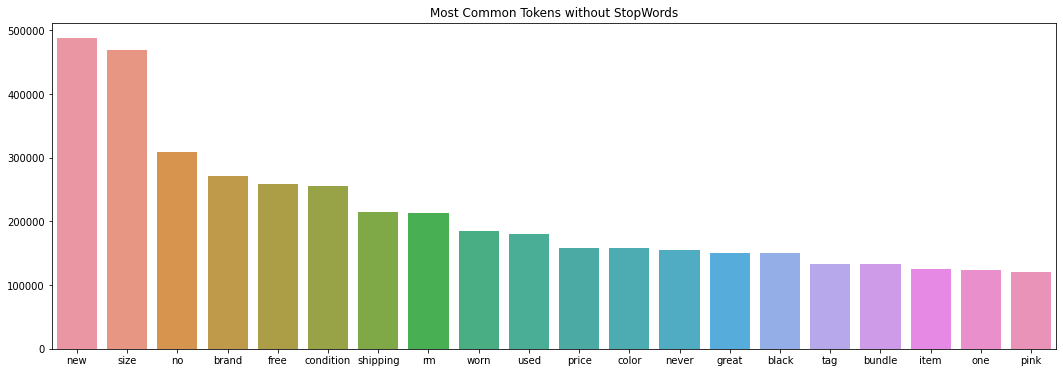


name clean up


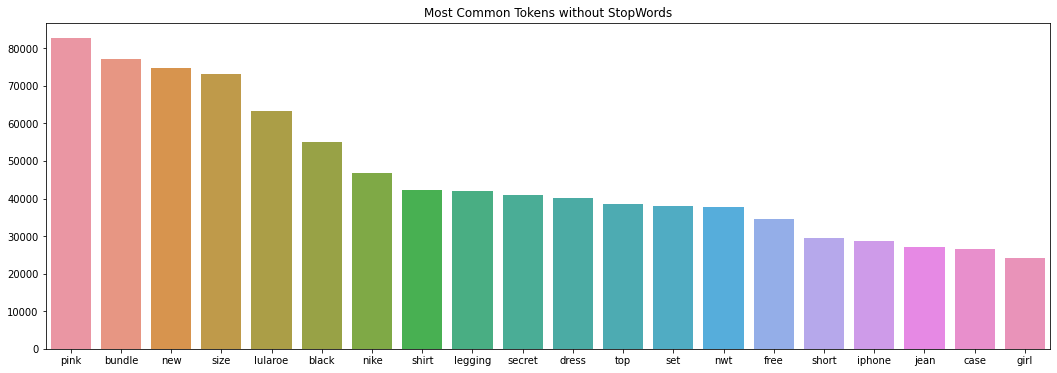

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,item_description_clean,name_clean
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,adorable top hint lace key hole back pale pink...,ava viv blouse
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,complete certificate authenticity,24k gold plated rose


In [17]:
data = preprocessData(data)
data.head()

description clean up


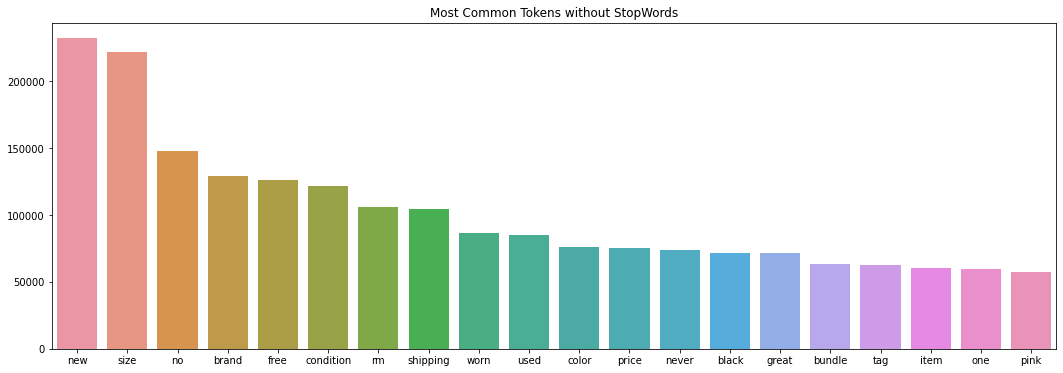


name clean up


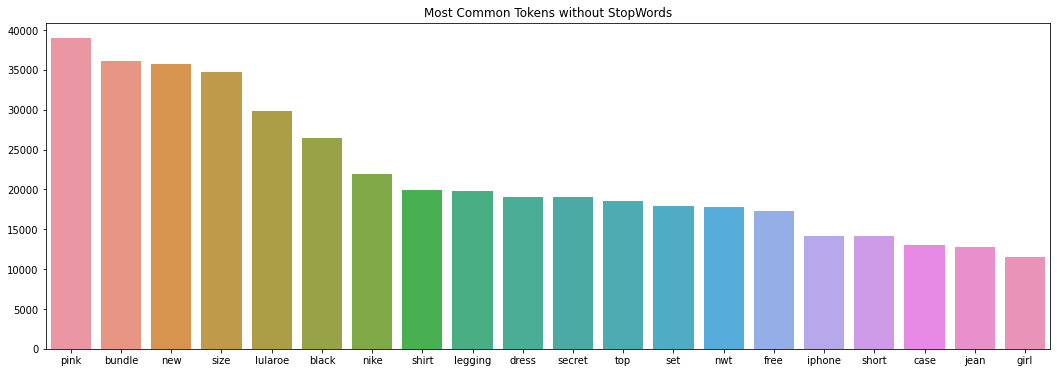

,name,item_condition_id,category_name,brand_name,shipping,item_description,item_description_clean,name_clean
0,"breast cancer ""i fight like a girl"" ring",1,Women/Jewelry/Rings,NA,1,size 7,size,breast cancer fight like girl ring
1,"25 pcs new 7.5""x12"" kraft bubble mailers",1,Other/Office supplies/Shipping Supplies,NA,1,"25 pcs new 7.5""x12"" kraft bubble mailers lined...",25 pc new x12 kraft bubble mailer lined bubble...,25 pc new x12 kraft bubble mailer
2,coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,brand new coach bag. bought for [rm] at a coac...,brand new coach bag bought rm coach outlet,coach bag
3,floral kimono,2,Women/Sweaters/Cardigan,NA,0,-floral kimono -never worn -lightweight and pe...,floral kimono never worn lightweight perfect h...,floral kimono
4,life after death,3,Other/Books/Religion & Spirituality,NA,1,rediscovering life after the loss of a loved o...,rediscovering life loss loved one tony cooke p...,life death


In [ ]:
test = preprocessData(test)
test.head()

# Load preprocessed

In [ ]:
# save preprocessed data train
force_overwrite = False
fname = 'train_preprocess.npy'

if force_overwrite or not os.path.isfile(fname):
  print("saving preprocess train data")
  data.to_pickle(fname)
else:
  print("loading existing preprocess train data")
  data = pd.read_pickle(fname)

loading existing preprocess train data


KeyboardInterrupt: ignored

In [ ]:
force_overwrite = False
fname = 'test_preprocess.npy'

if force_overwrite or not os.path.isfile(fname):
  print("saving preprocess test data")
  test.to_pickle(fname)
else:
  print("loading existing preprocess test data")
  test = pd.read_pickle(fname)

saving preprocess test data


# Encoding

In [18]:
# TODO ensure it is correct or use a well tested alternative like sklearn (found problems with dimensions)
class LabelEncoder:
  def __init__(self, unknown = 0, invUnknown = 'unknown'):
    self.leDict = {}
    self.invDict = {}
    self.unknown = unknown
    self.invUnknown = invUnknown

  def fit(self, data):
    vci = pd.value_counts(data).index
    self.leDict = dict(zip(vci, range(1, len(vci)+1)))
    self.invDict = dict(zip(range(1, len(vci)+1), vci))

  def transform1(self, item):
    return self.leDict.get(item, self.unknown)

  def transform(self, data):
    return data.apply(lambda item: self.transform1(item))

  def inverse_transform1(self, item):
    return self.invDict.get(item, self.invUnknown)

  def inverse_transform(self, data):
    return data.apply(lambda item: self.inverse_transform1(item))

In [19]:
cat_le = LabelEncoder()
cat_le.fit(np.hstack([data["category_name"], test["category_name"]]))

data["category_name_l"] = cat_le.transform(data["category_name"])
test["category_name_l"] = cat_le.transform(test["category_name"])

In [20]:
brand_le = LabelEncoder()
brand_le.fit(np.hstack([data["brand_name"], test["category_name"]]))

data["brand_name_l"] = brand_le.transform(data["brand_name"])
test["brand_name_l"] = brand_le.transform(test["brand_name"])

## Keras Embedding

In [21]:
# tokenize with keras; it also does some encoding
def tokenizeData(df, description, name, tokenizer= None, texts= None):
  if tokenizer == None:
    tokenizer = Tokenizer()

    print("fit tokenizer")
    tokenizer.fit_on_texts(texts)
  
  print('tokenize description')
  df["item_description_t"]=tokenizer.texts_to_sequences(df[description])

  print('tokenize name')
  df["name_t"]=tokenizer.texts_to_sequences(df[name])
  return df, tokenizer

In [22]:
texts = np.hstack([data["item_description_clean"], data["name_clean"]])

data_keras, tokenizer = tokenizeData(data ,"item_description_clean" ,"name_clean", None, texts)

fit tokenizer
tokenize description
tokenize name


In [ ]:
#data_keras_bk = data_keras
test_keras_bk = test_keras

NameError: ignored

In [23]:
data_keras=data_keras[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t", "price"]]
data_keras

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t,price
0,3,1,19,1,"[3, 37, 45]","[3362, 7816, 71, 31, 2, 99]",10.0
1,3,0,246,1074,"[2255, 17, 6, 78, 22, 966, 23, 1503, 628, 78, ...","[9329, 22452, 14222, 2255]",52.0
2,1,1,10,175,"[501, 26, 3940, 127, 577, 258, 59, 1698, 11, 5...","[6621, 9141, 525]",10.0
3,1,1,28,1,"[1, 19, 121, 1999, 80, 8, 809, 582, 75, 246, 8...","[121, 1999, 4697]",35.0
4,1,0,16,1,"[687, 5503, 1720]","[4228, 58, 941, 178]",44.0
...,...,...,...,...,...,...,...
1482530,2,1,245,96,"[127, 381, 2, 20, 24, 32, 589, 16, 13, 53, 49,...","[4, 473, 1472, 38]",20.0
1482531,2,0,124,23,"[103, 1136, 634, 38, 16, 12, 2, 862]","[103, 1136, 634, 38]",14.0
1482532,2,0,86,1,"[13, 272, 73, 17, 280]","[219, 46, 1326, 1038, 5880, 3035]",12.0
1482533,3,1,28,1,"[18, 85, 71, 310, 236, 71, 310, 18, 1155, 1944]","[1155, 1944, 4043]",45.0


In [ ]:
test_keras, _ = tokenizeData(test ,"item_description", "name", tokenizer)

tokenize description
tokenize name


In [ ]:
test_keras=test[["item_condition_id","shipping","category_name_l","brand_name_l", "item_description_t", "name_t"]]
test_keras

,item_condition_id,shipping,category_name_l,brand_name_l,item_description_t,name_t
0,1,1,34,1,"[6, 64]","[1809, 3592, 15, 5457, 51, 5, 265, 275]"
1,1,1,79,1,"[434, 808, 4, 64, 35, 8895, 5309, 614, 1018, 7...","[434, 808, 4, 64, 35, 8895, 5309, 614, 1018]"
2,1,1,203,21,"[16, 4, 308, 101, 198, 3, 22, 107, 5, 308, 3618]","[308, 101]"
3,2,0,45,1,"[281, 2183, 36, 30, 566, 1, 92, 3, 349, 1857]","[281, 2183]"
4,3,1,442,1,"[106728, 464, 297, 2, 1485, 11, 5, 1080, 46, 1...","[464, 297, 5311]"
...,...,...,...,...,...,...
693354,1,0,28,1,"[14078, 2150, 8103, 858, 42172, 43503, 154643,...","[2150, 825, 14, 14078, 842]"
693355,1,1,62,282,"[19, 608, 454, 27, 166, 993, 618, 7, 2142, 200...","[19, 608, 454, 27]"
693356,1,1,7,1,"[4, 13, 20, 63238, 89]","[438, 3226, 398, 1549, 89]"
693357,2,0,249,1,"[281, 2183, 2385, 221, 403, 180, 1440, 323, 27...","[1440, 323, 281, 2183]"


In [24]:
train_keras, validation_keras = train_test_split(data_keras, test_size=0.2, random_state=1000)

In [25]:
vocab_size= len(tokenizer.word_index)+1
print(vocab_size)
# clean 246054
# no clean 255431 (considerando tutto anche punteggiatura)

246054


In [26]:
train_keras[["item_description_t","name_t"]]

,item_description_t,name_t
233645,"[13, 43, 297, 2234, 133, 297, 1561, 5, 1, 2829...",[43]
1419447,"[5, 1, 54, 14, 84, 147]","[132, 1730, 3046, 2445, 54]"
935662,"[88, 13, 6, 1228, 7007, 361, 26, 2, 32, 359, 2...","[7007, 361, 26, 32]"
1147679,"[16, 13]",[8417]
766955,"[314, 37, 69, 5, 1, 16, 13]","[5216, 122, 1146]"
...,...,...
19252,"[3, 23, 471]","[395, 228, 1906, 160, 4773]"
385322,"[730, 683, 4445, 275, 296, 60]","[105, 730, 683, 4445, 275]"
138223,"[77, 11, 2, 32, 62, 87, 1836, 437, 17, 6, 160,...","[76, 1836, 437]"
1148150,"[250, 13, 7455, 43, 72, 36, 239, 80, 8, 90, 234]","[7455, 43, 72, 134, 36]"


In [27]:
desc_length_max=75
inputDesc_train_keras = pad_sequences(train_keras["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [28]:
inputDesc_validation_keras = pad_sequences(validation_keras["item_description_t"],
                                                  padding='post', maxlen=desc_length_max)

In [29]:
name_length_max=10
inputName_train_keras = pad_sequences(train_keras["name_t"], padding='post', maxlen=name_length_max)

In [30]:
inputName_validation_keras = pad_sequences(validation_keras["name_t"], padding='post', maxlen=name_length_max)

In [31]:
y_train_keras = train_keras["price"]
y_train_keras

233645     105.0
1419447     16.0
935662      26.0
1147679     14.0
766955       8.0
           ...  
19252       18.0
385322      54.0
138223      23.0
1148150     14.0
1185228     18.0
Name: price, Length: 1157452, dtype: float64

In [32]:
y_validation_keras = validation_keras["price"]
y_validation_keras

1378349     39.0
1186437     14.0
1356070    559.0
981120      54.0
1017699     25.0
           ...  
933953      10.0
1246650     30.0
1415233     10.0
376025      28.0
511335      19.0
Name: price, Length: 289363, dtype: float64

In [33]:
inputA_train_keras = train_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [34]:
inputA_validation_keras = validation_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [35]:
name_vocab_size= vocab_size
desc_vocab_size= vocab_size
def getModelKeras(name_length_max, desc_length_max, name_vocab_size, desc_vocab_size):
    inputA = Input(shape=(4,))
    #Ad = Dense(4, activation='relu')(inputA)
    Ad = inputA
    
    inputName = Input(shape=(name_length_max,))
    Ne = Embedding(input_dim=name_vocab_size, output_dim=8, input_length=name_length_max)(inputName)
    #Ne = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputName)
    Nd = Bidirectional(LSTM(12,return_sequences=True))(Ne)
    Nd =  GlobalMaxPool1D()(Nd)

    #Nd = Nf
    
    inputDesc = Input(shape=(desc_length_max,))
    De = Embedding(input_dim=desc_vocab_size, output_dim=16, input_length=desc_length_max)(inputDesc)
    #De = Embedding(
    #    num_tokens,
    #    embedding_dim,
    #    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    #    trainable=False,
    #)(inputDesc)
    Dd = Bidirectional(LSTM(16,return_sequences=True))(De)
    Dd = Bidirectional(LSTM(8,return_sequences=True))(Dd)
    
    Dd =  GlobalMaxPool1D()(Dd)
    #Dd = Df
    
    concat = Concatenate()([Ad, Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputA, inputName, inputDesc], outputs=x)
    
    return model
    

In [36]:
model_keras = getModelKeras(name_length_max, desc_length_max, name_vocab_size, desc_vocab_size)
model_keras.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 10)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 16)       3936864     input_3[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 10, 8)        1968432     input_2[0][0]                    
______________________________________________________________________________________________

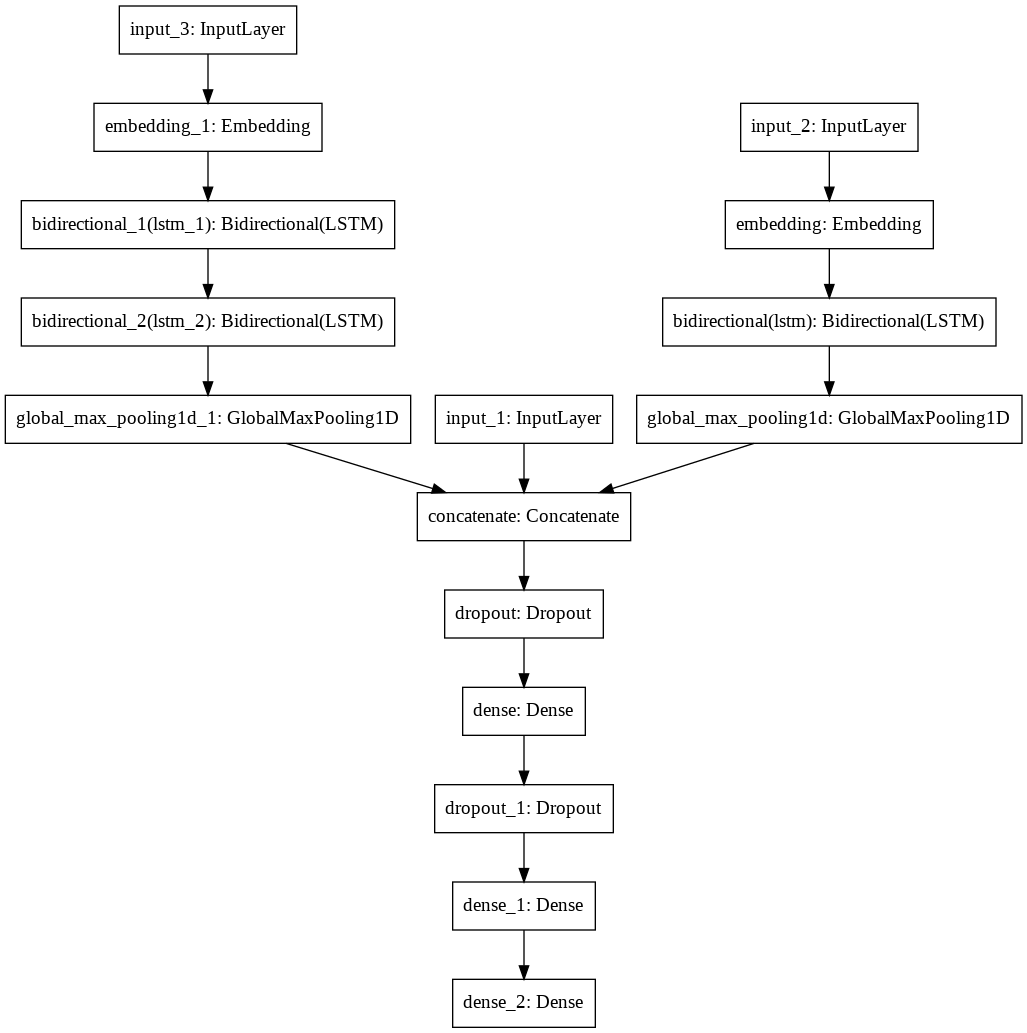

In [37]:
plot_model(model_keras)

In [38]:
model_keras.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

https://machinelearningmastery.com/clean-text-machine-learning-python/ ultima sezione

In [39]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

history_keras = model_keras.fit(x=[inputA_train_keras,inputName_train_keras, inputDesc_train_keras], y=y_train_keras,
                    epochs=5,
                    verbose=True,
                    validation_data=([inputA_validation_keras ,inputName_validation_keras, inputDesc_validation_keras], y_validation_keras),
                    callbacks=[callback],
                    batch_size=512)
# senza pulizia  loss: 0.4100  e val_root_mean_squared_logarithmic_error: 0.4543
# con pulizia leggera (lower)  val_root_mean_squared_logarithmic_error: 0.455 e loss: 0.4
# con pulizia val_root_mean_squared_logarithmic_error: 0.4643 e loss: 0.4269

Epoch 1/5
2261/2261 [==============================] - 180s 76ms/step - loss: 0.8734 - mse: 2772.3557 - mae: 20.3401 - root_mean_squared_error: 50.2806 - mean_squared_logarithmic_error: 1.0197 - root_mean_squared_logarithmic_error: 0.8734 - val_loss: 0.4972 - val_mse: 1083.3003 - val_mae: 11.8745 - val_root_mean_squared_error: 32.9135 - val_mean_squared_logarithmic_error: 0.2477 - val_root_mean_squared_logarithmic_error: 0.4973
Epoch 2/5
2261/2261 [==============================] - 168s 74ms/step - loss: 0.4972 - mse: 1089.2987 - mae: 11.8525 - root_mean_squared_error: 33.0015 - mean_squared_logarithmic_error: 0.2477 - root_mean_squared_logarithmic_error: 0.4972 - val_loss: 0.4750 - val_mse: 957.5197 - val_mae: 11.2617 - val_root_mean_squared_error: 30.9438 - val_mean_squared_logarithmic_error: 0.2261 - val_root_mean_squared_logarithmic_error: 0.4751
Epoch 3/5
2261/2261 [==============================] - 169s 75ms/step - loss: 0.4651 - mse: 987.5078 - mae: 11.0739 - root_mean_squared_e

In [ ]:
histDf = pd.DataFrame(history.history)
histDf.tail()

In [ ]:
histDf.plot(y=["loss", "val_loss"])

In [ ]:
inputA_test_keras = test_keras[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')
inputName_test_keras = pad_sequences(test_keras["name_t"], padding='post', maxlen=name_length_max)
inputDesc_test_keras = pad_sequences(test_keras["item_description_t"], padding='post', maxlen=desc_length_max)
pred_keras = model_keras.predict([inputA_test_keras, inputName_test_keras, inputDesc_test_keras])
pred_keras

In [ ]:
import math

def rmsle(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [ ]:
validation_keras

In [ ]:
pred_keras=pred_keras.round()

In [ ]:
pred_v_keras = model.predict([inputA_validation_keras, inputName_validation_keras, inputDesc_validation_keras])
pred_v_keras = pred_v_keras.round()

In [ ]:
len(pred_v_keras)

In [ ]:
len(y_validation_keras)

In [ ]:
root_mean_squared_logarithmic_error(y_validation_keras, pred_v_keras)

## Glove pretrained

In [ ]:
archive_url = 'http://downloads.cs.stanford.edu/nlp/data/wordvecs/glove.6B.zip'
archive_name = 'glove.6B.zip'
remove_archive = False
embedding_fname = 'glove.6B.100d.txt'

In [ ]:
if not os.path.isfile(archive_name) and not os.path.isfile(embedding_fname):
  ! wget {archive_url} -O {archive_name}

In [ ]:
if not os.path.isfile(embedding_fname):
  ! unzip {archive_name} {embedding_fname}

# remove archive if already extracted
if remove_archive and os.path.isfile(embedding_fname):
  os.remove(archive_name)

Needs a word encoding index (e.g. keras one)

In [ ]:
word_index = tokenizer.word_index
print(len(word_index))

In [ ]:
path_to_glove_file = os.path.join(
    base_dir, "glove.6B.100d.txt"
)

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

In [ ]:
#glove pretrained embedding
num_tokens = len(word_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

## BoW

In [ ]:
data.head()

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l,item_description_clean,name_clean
0,mlb cincinnati reds t shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,this keyboard is in great condition and works ...,246,1073,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top with a hint of lace and a key hol...,10,175,adorable top hint lace key hole back pale pink...,ava-viv blouse
3,leather horse statues,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new with tags. leather horses. retail for [rm]...,28,1,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete with certificate of authenticity,16,1,complete certificate authenticity,24k gold plated rose


In [ ]:
train_cvec, validation_cvec = train_test_split(data, test_size=0.2, random_state=1000)

In [ ]:
categorical_train_cvec= train_cvec[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print("Train:")
print(categorical_train_cvec.head())
print("\nValidation:")
categorical_validation_cvec= validation_cvec[["item_condition_id","shipping","category_name_l","brand_name_l"]]
print(categorical_validation_cvec.head())

Train:
         item_condition_id  shipping  category_name_l  brand_name_l
233645                   4         1               42             8
1419447                  1         0                6             1
935662                   3         1               29          1138
1147679                  2         0               77             1
766955                   1         1                4            18

Validation:
         item_condition_id  shipping  category_name_l  brand_name_l
1378349                  1         1                1             1
1186437                  1         0                1             5
1356070                  3         0              166             8
981120                   1         0                3           118
1017699                  1         1                6           129


In [ ]:
y_train_cvec=train_cvec["price"].values
y_validation_cvec=validation_cvec["price"].values

### Count Vectorizer

In [ ]:
vectorizer_desc = CountVectorizer()
vectorizer_desc.fit(data["item_description"].values)

KeyboardInterrupt: ignored

In [ ]:
len(vectorizer_desc.vocabulary_)

160142

In [ ]:
description_train_cvec = vectorizer_desc.transform(train_cvec["item_description"].values)

In [ ]:
description_validation_cvec = vectorizer_desc.transform(validation_cvec["item_description"].values)

In [ ]:
type(description_validation_cvec)

scipy.sparse.csr.csr_matrix

In [ ]:
vectorizer_name = CountVectorizer()
vectorizer_name.fit(data["name"].values)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [ ]:
len(vectorizer_name.vocabulary_)

104060

In [ ]:
name_train_cvec = vectorizer_name.transform(train_cvec["name"].values)
name_validation_cvec = vectorizer_name.transform(validation_cvec["name"].values)

In [ ]:
type(name_train_cvec)

scipy.sparse.csr.csr_matrix

In [ ]:
def getModel_bow(categorical_train, name_train, description_train):
    inputA = Input(categorical_train.shape[1])
    inputName = Input(name_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputName, inputDesc, inputA])

    x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputName ,inputDesc, inputA], outputs=x)

    return model

In [ ]:
model_cvec = getModel_bow(categorical_train_cvec, name_train_cvec, description_train_cvec)
model_cvec.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 104060)]     0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 160142)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 264206)       0           input_2[0][0]                    
                                                                 input_3[0][0]                

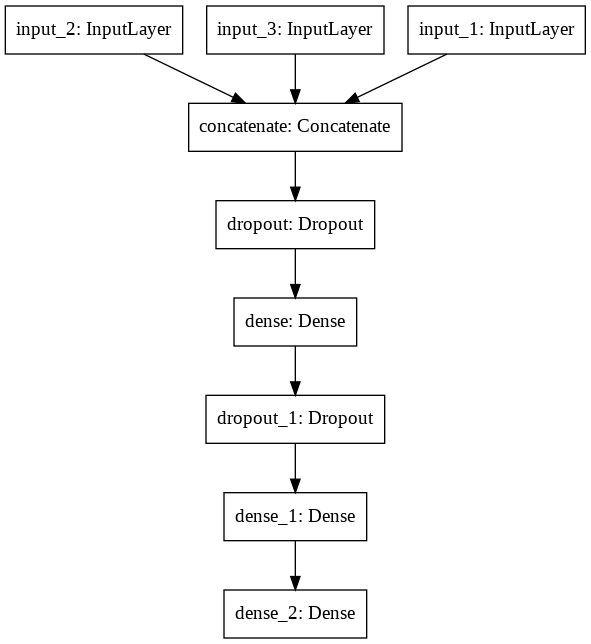

In [ ]:
plot_model(model_cvec)

In [ ]:
model_cvec.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
history_cvec = model_cvec.fit(x=[name_train_cvec, description_train_cvec, categorical_train_cvec.values],
                    y=y_train_cvec,
                    epochs=5,
                    verbose=True,
                    validation_data=(
                        [name_validation_cvec, description_validation_cvec, categorical_validation_cvec.values]
                        , y_validation_cvec),
                    batch_size=512)

Epoch 1/5
  67/2261 [..............................] - ETA: 5:58 - loss: 1.8163 - mse: 2388.3095 - mae: 25.9222 - root_mean_squared_error: 48.7976 - mean_squared_logarithmic_error: 3.5844 - root_mean_squared_logarithmic_error: 1.8163

KeyboardInterrupt: ignored

BOW con pulizia:
loss: 0.4549 - mse: 877.1694 - mae: 10.7754 - root_mean_squared_error: 29.6144 - mean_squared_logarithmic_error: 0.2073 - root_mean_squared_logarithmic_error: 0.4549 - val_loss: 0.4572 - val_mse: 823.4496 - val_mae: 10.7306 - val_root_mean_squared_error: 28.6958 - val_mean_squared_logarithmic_error: 0.2095 - val_root_mean_squared_logarithmic_error: 0.4573

BOW senza pulizia words:
loss: 0.4537 - mse: 892.7444 - mae: 10.7434 - root_mean_squared_error: 29.8743 - mean_squared_logarithmic_error: 0.2063 - root_mean_squared_logarithmic_error: 0.4537 - val_loss: 0.4554 - val_mse: 848.4371 - val_mae: 10.7117 - val_root_mean_squared_error: 29.1279 - val_mean_squared_logarithmic_error: 0.2079 - val_root_mean_squared_logarithmic_error: 0.4555

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    rmsle = history.history['root_mean_squared_logarithmic_error']
    val_rmsle = history.history['val_root_mean_squared_logarithmic_error']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(rmsle) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, rmsle, 'b', label='Training rmsle')
    plt.plot(x, val_rmsle, 'r', label='Validation rmsle')
    plt.title('Training and validation root_mean_squared_logarithmic_error')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

### TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
data["item_description"] = data["item_description_clean"]
data["name"] = data["name_clean"]

In [ ]:
tfidf_vectorizer_desc = TfidfVectorizer()
tfidf_vectorizer_desc.fit(data["item_description"].values)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
len(tfidf_vectorizer_desc.vocabulary_)

150074

In [ ]:
tfidf_description_train = tfidf_vectorizer_desc.transform(train_cvec["item_description"].values)
tfidf_description_validation = tfidf_vectorizer_desc.transform(validation_cvec["item_description"].values)

In [ ]:
tfidf_vectorizer_name = TfidfVectorizer()
tfidf_vectorizer_name.fit(data["name"])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [ ]:
len(tfidf_vectorizer_name.vocabulary_)

96904

In [ ]:
tfidf_name_train = tfidf_vectorizer_name.transform(train_cvec["name"])
tfidf_name_validation = tfidf_vectorizer_name.transform(validation_cvec["name"])

In [ ]:
tfidf_name_train

<1157452x96904 sparse matrix of type '<class 'numpy.float64'>'
	with 4777783 stored elements in Compressed Sparse Row format>

In [ ]:
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

In [ ]:
def convert_sparse_matrix_to_sparse_tensor(X):
    coo = X.tocoo()
    indices = np.mat([coo.row, coo.col]).transpose()
    return tf.SparseTensor(indices, coo.data, coo.shape)

In [ ]:
type(tfidf_name_train) 

scipy.sparse.csr.csr_matrix

In [ ]:
#https://stackoverflow.com/questions/61961042/indices201-0-8-is-out-of-order-many-sparse-ops-require-sorted-indices-use

In [ ]:
import scipy
new_categorical_train_cvec=scipy.sparse.csr_matrix(categorical_train_cvec.values)
new_categorical_validation_cvec=scipy.sparse.csr_matrix(categorical_validation_cvec.values)

In [ ]:
new_tfidf_categorical_validation=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(new_categorical_validation_cvec))
new_tfidf_categorical_train=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(new_categorical_train_cvec))

In [ ]:
new_tfidf_name_validation=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(tfidf_name_validation))
new_tfidf_name_train=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(tfidf_name_train))

In [ ]:
type(new_tfidf_name_validation)

tensorflow.python.framework.sparse_tensor.SparseTensor

In [ ]:
type(tfidf_name_validation)

scipy.sparse.csr.csr_matrix

In [ ]:
new_tfidf_description_validation=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(tfidf_description_validation))
new_tfidf_description_train=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(tfidf_description_train))

In [ ]:
new_y_train_cvec=scipy.sparse.csr_matrix(y_train_cvec)
new_y_validation_cvec=scipy.sparse.csr_matrix(y_validation_cvec)

In [ ]:
new_tfidf_y_validation=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(new_y_validation_cvec))
new_tfidf_y_train=tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(new_y_train_cvec))

In [ ]:
type(tf.sparse.reorder(convert_sparse_matrix_to_sparse_tensor(new_y_train_cvec)))

tensorflow.python.framework.sparse_tensor.SparseTensor

In [ ]:
def getModel_bow(name_train, description_train, categorical_train):
    inputA = Input(categorical_train.shape[1])
    inputName = Input(name_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputName, inputDesc])#, inputA])

    #x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(concat)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputName ,inputDesc], outputs=x)

    return model

In [ ]:
model = getModel_bow(new_tfidf_name_train, new_tfidf_description_train, new_tfidf_categorical_train)
model.summary() 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 96904)]      0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 150074)]     0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 246978)       0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 32)           7903328     concatenate_1[0][0]        

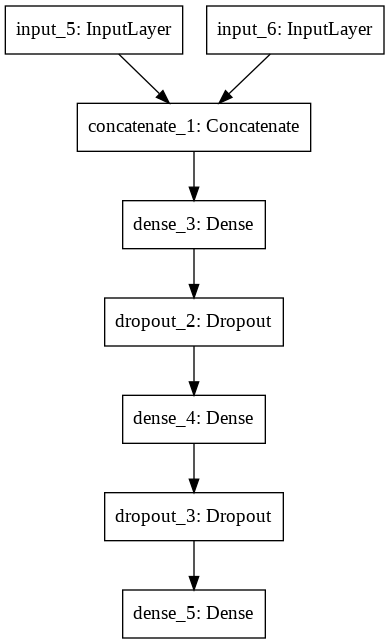

In [ ]:
plot_model(model)

In [ ]:
model.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
data

,name,item_condition_id,category_name,brand_name,price,shipping,item_description,category_name_l,brand_name_l,item_description_clean,name_clean
0,mlb cincinnati red shirt size xl,3,Men/Tops/T-shirts,NA,10.0,1,no description yet,19,1,no description yet,mlb cincinnati red shirt size xl
1,razer blackwidow chroma keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,keyboard great condition work like came box po...,246,1073,keyboard great condition work like came box po...,razer blackwidow chroma keyboard
2,ava-viv blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,adorable top hint lace key hole back pale pink...,10,175,adorable top hint lace key hole back pale pink...,ava-viv blouse
3,leather horse statue,1,Home/Home Décor/Home Décor Accents,NA,35.0,1,new tag leather horse retail rm stand foot hig...,28,1,new tag leather horse retail rm stand foot hig...,leather horse statue
4,24k gold plated rose,1,Women/Jewelry/Necklaces,NA,44.0,0,complete certificate authenticity,16,1,complete certificate authenticity,24k gold plated rose
...,...,...,...,...,...,...,...,...,...,...,...
1482530,free people inspired dress,2,Women/Dresses/Mid-Calf,Free People,20.0,1,lace say size small fit medium perfectly never...,245,96,lace say size small fit medium perfectly never...,free people inspired dress
1482531,little mermaid handmade dress,2,Kids/Girls 2T-5T/Dresses,Disney,14.0,0,little mermaid handmade dress never worn size 2t,124,23,little mermaid handmade dress never worn size 2t,little mermaid handmade dress
1482532,21 day fix container eating plan,2,Sports & Outdoors/Exercise/Fitness accessories,NA,12.0,0,used twice still great shape,85,1,used twice still great shape,21 day fix container eating plan
1482533,world market lantern,3,Home/Home Décor/Home Décor Accents,NA,45.0,1,2 one see 2 red 2 orange 2 big red orange one ...,28,1,2 one see 2 red 2 orange 2 big red orange one ...,world market lantern


In [ ]:
history = model.fit(x=[new_tfidf_name_train, new_tfidf_description_train], y=y_train_cvec,
                    epochs=5,
                    verbose=True,
                    validation_data=([new_tfidf_name_validation, new_tfidf_description_validation], y_validation_cvec),
                    batch_size=512)

Epoch 1/5
2261/2261 [==============================] - 33s 14ms/step - loss: 0.8997 - mse: 1581.8329 - mae: 16.4082 - root_mean_squared_error: 39.6708 - mean_squared_logarithmic_error: 1.1829 - root_mean_squared_logarithmic_error: 0.8997 - val_loss: 0.5067 - val_mse: 1097.8687 - val_mae: 12.1188 - val_root_mean_squared_error: 33.1341 - val_mean_squared_logarithmic_error: 0.2572 - val_root_mean_squared_logarithmic_error: 0.5068
Epoch 2/5
2261/2261 [==============================] - 33s 14ms/step - loss: 0.5017 - mse: 1173.8495 - mae: 11.9998 - root_mean_squared_error: 34.2467 - mean_squared_logarithmic_error: 0.2522 - root_mean_squared_logarithmic_error: 0.5017 - val_loss: 0.4794 - val_mse: 963.8772 - val_mae: 11.3596 - val_root_mean_squared_error: 31.0464 - val_mean_squared_logarithmic_error: 0.2303 - val_root_mean_squared_logarithmic_error: 0.4795
Epoch 3/5
2261/2261 [==============================] - 33s 14ms/step - loss: 0.4654 - mse: 987.2503 - mae: 11.0919 - root_mean_squared_erro

In [ ]:
history2 = model.fit(x=[new_tfidf_name_train, new_tfidf_description_train], y=y_train_cvec,
                    epochs=5,
                    verbose=True,
                    validation_data=([new_tfidf_name_validation, new_tfidf_description_validation], y_validation_cvec),
                    batch_size=512)

Epoch 1/5
2261/2261 [==============================] - 35s 15ms/step - loss: 0.3684 - mse: 655.2321 - mae: 8.7298 - root_mean_squared_error: 25.5975 - mean_squared_logarithmic_error: 0.1360 - root_mean_squared_logarithmic_error: 0.3684 - val_loss: 0.4688 - val_mse: 740.2447 - val_mae: 10.7062 - val_root_mean_squared_error: 27.2074 - val_mean_squared_logarithmic_error: 0.2202 - val_root_mean_squared_logarithmic_error: 0.4689
Epoch 2/5
2261/2261 [==============================] - 34s 14ms/step - loss: 0.3623 - mse: 635.2028 - mae: 8.5716 - root_mean_squared_error: 25.2032 - mean_squared_logarithmic_error: 0.1316 - root_mean_squared_logarithmic_error: 0.3623 - val_loss: 0.4699 - val_mse: 743.9951 - val_mae: 10.6838 - val_root_mean_squared_error: 27.2763 - val_mean_squared_logarithmic_error: 0.2213 - val_root_mean_squared_logarithmic_error: 0.4701
Epoch 3/5
2261/2261 [==============================] - 33s 14ms/step - loss: 0.3569 - mse: 618.5656 - mae: 8.4365 - root_mean_squared_error: 24.

In [ ]:
histdf = pd.DataFrame(history2.history)

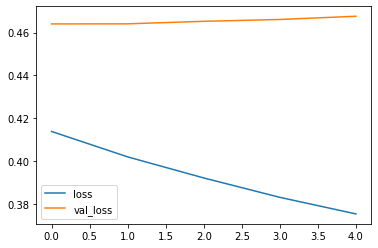

In [ ]:
histdf.plot(y=["loss", "val_loss"])

tf-idf gensim

In [ ]:
import gensim
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import TfidfModel

In [ ]:
data["item_description"]

0                                         no description yet
1          this keyboard is in great condition and works ...
2          adorable top with a hint of lace and a key hol...
3          new with tags. leather horses. retail for [rm]...
4                  complete with certificate of authenticity
                                 ...                        
1482530    lace, says size small but fits medium perfectl...
1482531     little mermaid handmade dress never worn size 2t
1482532            used once or twice, still in great shape.
1482533    there is 2 of each one that you see! so 2 red ...
1482534    new with tag, red with sparkle. firm price, no...
Name: item_description, Length: 1446815, dtype: string

In [ ]:
doc_tokenized = [simple_preprocess(doc) for doc in data["item_description"].values]

In [ ]:
doc_tokenized[0]

['no', 'description', 'yet']

In [ ]:
dictionary = corpora.Dictionary()

In [ ]:
BoW_corpus = [dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized]

In [ ]:
# stampa le parole che compaiono in ogni descrizione con la loro frequenza di apparizione
for doc in BoW_corpus[:10]:
   print([[dictionary[id], freq] for id, freq in doc])

[['description', 1], ['no', 1], ['yet', 1]]
[['all', 1], ['and', 2], ['app', 1], ['are', 2], ['box', 1], ['came', 1], ['condition', 1], ['customizable', 1], ['great', 1], ['in', 1], ['is', 1], ['it', 1], ['keyboard', 1], ['lights', 1], ['like', 1], ['of', 2], ['on', 1], ['out', 1], ['pc', 1], ['perfectly', 1], ['ports', 1], ['razer', 1], ['synapse', 1], ['tested', 1], ['the', 4], ['this', 1], ['via', 1], ['work', 1], ['works', 1], ['your', 1]]
[['and', 2], ['in', 2], ['is', 1], ['of', 1], ['the', 2], ['adorable', 1], ['also', 1], ['available', 1], ['back', 1], ['have', 1], ['hint', 1], ['hole', 1], ['key', 1], ['lace', 1], ['pale', 1], ['pink', 1], ['top', 1], ['white', 1], ['with', 1]]
[['are', 1], ['of', 1], ['out', 1], ['with', 1], ['about', 1], ['any', 1], ['as', 1], ['ask', 1], ['being', 1], ['each', 1], ['foot', 1], ['for', 1], ['free', 1], ['got', 1], ['high', 1], ['horses', 1], ['just', 1], ['leather', 1], ['new', 1], ['pair', 1], ['please', 1], ['questions', 1], ['retail', 1],

In [ ]:
tfidf = TfidfModel(BoW_corpus)

In [ ]:
for doc in tfidf[BoW_corpus]:
   print([[dictionary[id], np.around(freq)] for id, freq in doc])

[['description', 0.64], ['no', 0.39], ['yet', 0.66]]
[['all', 0.08], ['and', 0.07], ['app', 0.21], ['are', 0.16], ['box', 0.09], ['came', 0.19], ['condition', 0.06], ['customizable', 0.3], ['great', 0.08], ['in', 0.05], ['is', 0.06], ['it', 0.07], ['keyboard', 0.25], ['lights', 0.21], ['like', 0.09], ['of', 0.12], ['on', 0.07], ['out', 0.1], ['pc', 0.19], ['perfectly', 0.18], ['ports', 0.25], ['razer', 0.35], ['synapse', 0.44], ['tested', 0.18], ['the', 0.2], ['this', 0.08], ['via', 0.2], ['work', 0.15], ['works', 0.14], ['your', 0.1]]
[['and', 0.12], ['in', 0.15], ['is', 0.09], ['of', 0.1], ['the', 0.17], ['adorable', 0.28], ['also', 0.2], ['available', 0.21], ['back', 0.18], ['have', 0.14], ['hint', 0.44], ['hole', 0.33], ['key', 0.32], ['lace', 0.24], ['pale', 0.37], ['pink', 0.15], ['top', 0.18], ['white', 0.17], ['with', 0.08]]
[['are', 0.11], ['of', 0.08], ['out', 0.13], ['with', 0.07], ['about', 0.19], ['any', 0.14], ['as', 0.13], ['ask', 0.16], ['being', 0.25], ['each', 0.18], 

In [ ]:
data["tfidf"]=tfidf[BoW_corpus]

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
len(data.iloc[10]["tfidf"])

8

In [ ]:
train_tfidf, validation_tfidf = train_test_split(data[["item_condition_id", "shipping", "category_name_l",	"brand_name_l", "tfidf", "price"]], test_size=0.2, random_state=1000)

In [ ]:
train_tfidf_categorical=train_tfidf[["item_condition_id", "shipping", "category_name_l",	"brand_name_l"]]
validation_tfidf_categorical=validation_tfidf[["item_condition_id", "shipping", "category_name_l",	"brand_name_l"]]


train_tfidf_description=train_tfidf["tfidf"]
validation_tfidf_description=validation_tfidf["tfidf"]

y_train=train_tfidf["price"]
y_validation=validation_tfidf["price"]

In [ ]:
(validation_tfidf_description[0:10].todense)

AttributeError: ignored

In [ ]:
def getModel_bow(categorical_train, description_train):
    inputA = Input(categorical_train.shape[1])
    inputDesc = Input(description_train.shape[1])
    concat = Concatenate()([inputDesc, inputA])

    x = Dropout(0.1)(concat)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[inputDesc, inputA], outputs=x)

    return model

In [ ]:
model = getModel_bow(train_tfidf_categorical ,train_tfidf_description)
model.summary() 

IndexError: ignored

In [ ]:
train_tfidf_description.shape

(1157452,)

# Transformers

In [ ]:
pret_model_trans = TFDistilBertModel.from_pretrained('distilbert-base-uncased')
pret_model_trans.trainable = False

tokenizer_trans = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_projector', 'activation_13', 'vocab_layer_norm', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
data = data[0:10000]

In [ ]:
train_trans, validation_trans = train_test_split(data, test_size=0.2, random_state=1000)

In [ ]:
y_train_trans = train_trans["price"]
y_train_trans

5839     8.0
630     30.0
2800    16.0
6106     5.0
7215    13.0
        ... 
2458    32.0
3870     7.0
6363     6.0
4818    11.0
9891    75.0
Name: price, Length: 8000, dtype: float64

In [ ]:
y_validation_trans = validation_trans["price"]
y_validation_trans

8228    20.0
7300    19.0
7761    34.0
7531    48.0
3325     7.0
        ... 
9574    60.0
9501    30.0
3876    71.0
5611    60.0
7453    15.0
Name: price, Length: 2000, dtype: float64

todo: use cleaned? or let bert handle everything?

In [ ]:
inputA_train_trans = train_trans[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputA_validation_trans = validation_trans[["item_condition_id", "category_name_l", "brand_name_l", "shipping"]].values.astype('int32')

In [ ]:
inputName_train_trans = tokenizer_trans(train_trans["name"].to_list(),
                                  return_tensors="tf",
                                  padding=True)
#inputName_trans

In [ ]:
inputName_validation_trans = tokenizer_trans(validation_trans["name"].to_list(),
                                  return_tensors="tf",
                                  padding=True)
#inputName_trans

In [ ]:
inputName_shape_trans = (inputName_train_trans['input_ids'].shape[1],
                         inputName_train_trans['attention_mask'].shape[1])

inputName_shape_trans

(19, 19)

In [ ]:
inputDesc_train_trans = tokenizer_trans(train_trans["item_description"].to_list(),
                                  return_tensors="tf",
                                  padding=True)

In [ ]:
inputDesc_validation_trans = tokenizer_trans(validation_trans["item_description"].to_list(),
                                  return_tensors="tf",
                                  padding=True)

In [ ]:
inputDesc_shape_trans = (inputDesc_train_trans['input_ids'].shape[1],
                         inputDesc_train_trans['attention_mask'].shape[1])
inputDesc_shape_trans

(337, 337)

In [ ]:
def getModel_trans():
    inputA = Input(shape=(4,))
    Ad = inputA    
    
    inputName_ids = Input(shape=(inputName_shape_trans[0],), dtype='int32')
    inputName_mask = Input(shape=(inputName_shape_trans[1],), dtype='int32')

    Np = pret_model_trans(inputName_ids, attention_mask=inputName_mask)[0]

    Nd = LSTM(12,return_sequences=True)(Np)
    Nd = Flatten()(Nd)

    inputDesc_ids = Input(shape=(inputDesc_shape_trans[0],), dtype='int32')
    inputDesc_mask = Input(shape=(inputDesc_shape_trans[1],), dtype='int32')

    Dp = pret_model_trans(inputDesc_ids, attention_mask=inputDesc_mask)[0]

    Dd = LSTM(16,return_sequences=True)(Dp)
    Dd = LSTM(8,return_sequences=True)(Dd)
    Dd = Flatten()(Dd)

    concat = Concatenate()([Nd, Dd])

    x = Dropout(0.1)(concat)    
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(16, activation='relu')(x)
    
    x = Dense(1, activation='linear')(x)
    
    model = Model(inputs=[
                          inputA,
                          inputName_ids,
                          inputName_mask,
                          inputDesc_ids,
                          inputDesc_mask
                          ], outputs=x)
    
    return model
    

In [ ]:
model_trans = getModel_trans()

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


In [ ]:
model_trans.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 19)]         0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 337)]        0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, 337)]        0                                            
____________________________________________________________________________________________

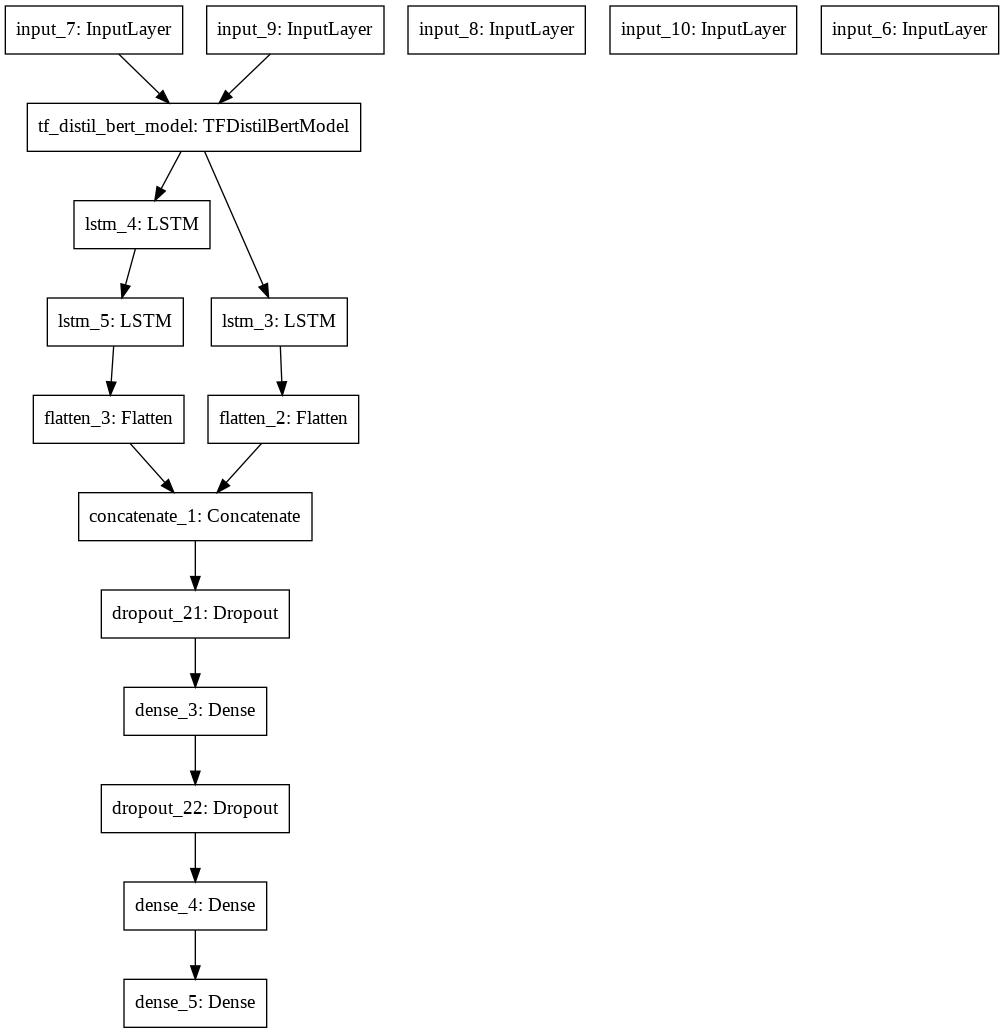

In [ ]:
plot_model(model_trans)

In [ ]:
model_trans.compile(loss = root_mean_squared_logarithmic_error, optimizer='adam', metrics=['mse', 'mae', tf.keras.metrics.RootMeanSquaredError(), 'mean_squared_logarithmic_error', root_mean_squared_logarithmic_error])

In [ ]:
history_trans = model_trans.fit(x=[inputA_train_trans,
                   inputName_train_trans['input_ids'],
                   inputName_train_trans['attention_mask'],
                   inputDesc_train_trans['input_ids'],
                   inputDesc_train_trans['attention_mask']
                  ],
                   y=y_train_trans,
                    epochs=2,
                    verbose=True,
                    validation_data=([
                                      inputA_validation_trans,
                                      inputName_validation_trans['input_ids'],
                                      inputName_validation_trans['attention_mask'],
                                      inputDesc_validation_trans['input_ids'],
                                      inputDesc_validation_trans['attention_mask'],
                                      ], 
                                     y_validation_trans),
                    batch_size=512)

The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


Epoch 1/2


The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.
The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).
The parameter `return_dict` cannot be set in graph mode and will always be set to `True`.


 1/16 [>.............................] - ETA: 5:57 - loss: 3.0865 - mse: 2804.8843 - mae: 28.2025 - root_mean_squared_error: 52.9612 - mean_squared_logarithmic_error: 9.5266 - root_mean_squared_logarithmic_error: 3.0865